### Import Necessary Modules and Libraries

In [1]:
!pip install opencv-python
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('Modules Loaded')


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Modules Loaded


### Definition of Support Functions

#### Function to Show Example Training Images

In [2]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    

    # Get a sample batch from the generator 
    images, labels = next(gen)

    # Create a figure to display the images
    plt.figure(figsize=(20, 20))

    # Determine the number of images to display (maximum 25)
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25

    # Loop through the images and display them with labels
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        
        # Normalize the image data
        image = images[i] / 255
        
        # Display the image
        plt.imshow(image)
        
        # Get the index of the maximum label value
        index = np.argmax(labels[i])
        
        # Get the class name associated with the index
        class_name = classes[index]
        
        # Set the title of the subplot
        plt.title(class_name, color='blue', fontsize=12)
        
        # Turn off axis for cleaner display
        plt.axis('off')

    # Display the entire plot
    plt.show()

In [3]:
def show_images(tdir):
    # Get the list of class names from the directory
    classlist = os.listdir(tdir)
    length = len(classlist)
    
    # Calculate the number of rows and columns for subplots
    columns = 5
    rows = int(np.ceil(length / columns))
    
    # Create a figure to display the images
    plt.figure(figsize=(20, rows * 4))
    
    # Loop through each class and display an image
    for i, klass in enumerate(classlist):
        # Construct the path to the class directory
        classpath = os.path.join(tdir, klass)
        
        # Get the path to the first image in the class
        imgpath = os.path.join(classpath, '1.jpg')
        
        # Read the image using plt.imread
        img = plt.imread(imgpath)
        
        # Create a subplot for the image
        plt.subplot(rows, columns, i + 1)
        
        # Turn off axis for cleaner display
        plt.axis('off')
        
        # Set the title of the subplot to the class name
        plt.title(klass, color='blue', fontsize=12)
        
        # Display the image
        plt.imshow(img)

#### Function to Print Text in RGB Foreground and Background Colors

In [4]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Define the function to print text in specified foreground and background colors
    # txt_msg: The text to be printed
    # fore_tupple: Tuple representing foreground color (r, g, b)
    # back_tupple: Tuple representing background color (r, g, b)
    
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    
    # Construct the ANSI escape sequence for foreground and background color
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    
    # Print the formatted text message with colors
    msg = '{0}' + txt_msg
    print(msg.format(mat), flush=True)
    
    # Reset the print color back to default (black)
    print('\33[0m', flush=True)
    
    # Return to indicate the function has completed
    return

#### Function Definition for Custom Callback

In [5]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

#### Function to Plot the Training Data

In [6]:
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']  # Training accuracy values
    tloss = tr_data.history['loss']  # Training loss values
    vacc = tr_data.history['val_accuracy']  # Validation accuracy values
    vloss = tr_data.history['val_loss']  # Validation loss values
    
    Epoch_count = len(tacc) + start_epoch  # Total number of epochs including the starting epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)  # Create a list of epoch numbers
        
    # Find the epoch with the lowest validation loss
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]  # The lowest validation loss value
    
    # Find the epoch with the highest validation accuracy
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]  # The highest validation accuracy value
    
    plt.style.use('fivethirtyeight')
    
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)  # Label for lowest validation loss point
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)  # Label for highest validation accuracy point
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Plot training and validation loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)  # Mark lowest loss point
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Plot training and validation accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)  # Mark highest accuracy point
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()  # Adjust subplot layout
    
    # Display the plot
    plt.show()

#### Function to Create Confusion Matrix and Classification Report

In [7]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    # Extract class information and prediction data
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    
    # Create a dictionary to map integer class numbers to string class names
    for key, value in class_dict.items():
        new_dict[value] = key
        
    classes = list(new_dict.values())  # List of string class names
    errors = 0
    
    # Loop through predictions to identify misclassifications
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # Labels are integer values
        
        if pred_index != true_index:  # Misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        
        y_pred.append(pred_index)
        
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
                
            # Print misclassification details
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
                
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            
    if errors > 0:
        # Generate a bar plot of error count by class
        plot_bar = []
        plot_class = []
        
        for key, value in new_dict.items():
            count = error_indices.count(key)
            
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
                
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            
        plt.title('Errors by Class on Test Set')
        
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    
    if len(classes) <= 30:
        # Generate a confusion matrix if number of classes is manageable
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
            
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        
    # Print classification report
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

#### Function to Save the Model and the Associated class_dict.csv File

In [8]:
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # Print the provided save path
    print('the save path is: ', save_path)
    
    # Create a unique identifier for the saved model
    save_id = str(model_name + '-' + subject + '-' + str(accuracy)[:str(accuracy).rfind('.') + 3] + '.h5')
    
    # Construct the full save path for the model
    model_save_loc = os.path.join(save_path, save_id)
    
    # Save the model
    model.save(model_save_loc)
    
    # Print a message indicating that the model was saved
    print_in_color('model was saved as ' + model_save_loc, (0, 255, 0), (55, 65, 80))
    
    # Prepare data for creating the class_df CSV file
    class_dict = generator.class_indices 
    height = []
    width = []
    scale = []
    
    # Populate height, width, and scale lists
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    
    # Create Series for various data elements
    Index_series = pd.Series(list(class_dict.values()), name='class_index')
    Class_series = pd.Series(list(class_dict.keys()), name='class') 
    Height_series = pd.Series(height, name='height')
    Width_series = pd.Series(width, name='width')
    Scale_series = pd.Series(scale, name='scale by')
    
    # Concatenate Series to create the class_df DataFrame
    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    
    # Define the CSV file name
    csv_name = 'class_dict.csv'
    
    # Construct the full save path for the class_df CSV file
    csv_save_loc = os.path.join(save_path, csv_name)
    
    # Save the class_df DataFrame as a CSV file
    class_df.to_csv(csv_save_loc, index=False)
    
    # Print a message indicating that the class CSV file was saved
    print_in_color('class csv file was saved as ' + csv_save_loc, (0, 255, 0), (55, 65, 80))
    
    # Return the paths of the saved model and class CSV file
    return model_save_loc, csv_save_loc

#### Function to Use the Trained Model and the class_dict.csv file to Predict Images

In [9]:
def predictor(sdir, csv_path, model_path, averaged=True, verbose=True):    
    # Read in the class dataframe from the provided CSV file
    class_df = pd.read_csv(csv_path)
    
    # Extract information from the class dataframe
    class_count = len(class_df['class'].unique())
    img_height = int(class_df['height'].iloc[0])
    img_width = int(class_df['width'].iloc[0])
    img_size = (img_width, img_height)
    scale = class_df['scale by'].iloc[0]
    
    # Determine the value to scale image pixels by
    try: 
        s = int(scale)
        s2 = 1
        s1 = 0
    except:
        split = scale.split('-')
        s1 = float(split[1])
        s2 = float(split[0].split('*')[1])
    
    # Create a list of image paths in the provided directory
    path_list = []
    paths = os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir, f))
    
    if verbose:
        print('Model is being loaded - this will take about 10 seconds')
    
    # Load the trained model
    model = load_model(model_path)
    image_count = len(path_list) 
    image_list = []
    file_list = []
    good_image_count = 0
    
    # Process each image in the directory
    for i in range(image_count):        
        try:
            img = cv2.imread(path_list[i])
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            good_image_count += 1
            img = img * s2 - s1             
            image_list.append(img)
            file_name = os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print(path_list[i], ' is an invalid image file')
    
    if good_image_count == 1:  # If only a single image, need to expand dimensions
        averaged = True
    
    image_array = np.array(image_list)
    
    # Make predictions on the images
    preds = model.predict(image_array)
    
    if averaged:
        psum = [0] * class_count
        
        # Calculate the sum of probabilities for each class
        for p in preds:
            for i in range(class_count):
                psum[i] = psum[i] + p[i]
        
        # Find the class index with the highest probability sum
        index = np.argmax(psum)
        
        # Get the predicted class name and probability
        klass = class_df['class'].iloc[index]
        prob = psum[index] / good_image_count * 100
        
        # Iterate through images to find the correct image representing the predicted class
        for img in image_array:
            test_img = np.expand_dims(img, axis=0)
            test_index = np.argmax(model.predict(test_img))
            if test_index == index:
                if verbose:
                    plt.axis('off')
                    plt.imshow(img)
                    print(f'predicted species is {klass} with a probability of {prob:6.4f} % ')
                break
                
        return klass, prob, img, None
    else:
        pred_class = []
        prob_list = []
        
        # Create individual predictions for each image
        for i, p in enumerate(preds):
            index = np.argmax(p)
            klass = class_df['class'].iloc[index]
            image_file = file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
            
        Fseries = pd.Series(file_list, name='image file')
        Lseries = pd.Series(pred_class, name='species')
        Pseries = pd.Series(prob_list, name='probability')
        
        # Create a DataFrame containing prediction results
        df = pd.concat([Fseries, Lseries, Pseries], axis=1)
        
        if verbose:
            length = len(df)
            print(df.head(length))
        
        return None, None, None, df

#### Function that takes in a dataframe, integer max_size and a string column and returns a dataframe where the number of samples for any class specified by column is limited to max samples

In [10]:
def trim(df, max_size, min_size, column):
    df = df.copy()  # Create a copy of the dataframe
    original_class_count = len(list(df[column].unique()))  # Get the original number of unique classes
    
    print('Original Number of classes in dataframe:', original_class_count)
    
    sample_list = []  # List to store balanced samples for each class
    groups = df.groupby(column)  # Group the dataframe by the specified column
    
    for label in df[column].unique():  # Iterate through unique class labels
        group = groups.get_group(label)  # Get the group corresponding to the current class
        sample_count = len(group)  # Number of samples in the current class
        
        if sample_count > max_size:
            strat = group[column]  # Stratify based on the current class
            # Split the group into train and test sets, with train_size=max_size
            samples, _ = train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)
            sample_list.append(samples)  # Append the balanced samples to the list
        elif sample_count >= min_size:
            sample_list.append(group)  # If sample_count is within the desired range, keep all samples
    
    # Concatenate the balanced samples back into a single dataframe
    df = pd.concat(sample_list, axis=0).reset_index(drop=True)
    
    final_class_count = len(list(df[column].unique()))  # Get the final number of unique classes after trimming
    
    if final_class_count != original_class_count:
        print('*** WARNING***  dataframe has a reduced number of classes')
    
    balance = list(df[column].value_counts())  # Get the class balance after trimming
    print(balance)
    
    return df

In [11]:
def balance(train_df, max_samples, min_samples, column, working_dir, image_size):
    train_df = train_df.copy()  # Make a copy of the input DataFrame
    train_df = trim(train_df, max_samples, min_samples, column)  # Trim the DataFrame based on class sizes
    
    # Create directories to store augmented images
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    
    for label in train_df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    
    # Create and store augmented images using ImageDataGenerator
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=.2,
                             height_shift_range=.2, zoom_range=.2)
    
    groups = train_df.groupby('labels')  # Group the DataFrame by class
    for label in train_df['labels'].unique():
        group = groups.get_group(label)  # DataFrame holding rows with the specified label
        sample_count = len(group)  # Number of samples in this class
        
        if sample_count < max_samples:  # If the class has fewer samples than the target
            aug_img_count = 0
            delta = max_samples - sample_count  # Number of augmented images to create
            target_dir = os.path.join(aug_dir, label)  # Where to write the images
            
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=image_size,
                                              class_mode=None, batch_size=1, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            
            total += aug_img_count
    
    print('Total Augmented images created:', total)
    
    # Create aug_df and merge with train_df to create the composite training set train_df
    if total > 0:
        aug_fpaths = []
        aug_labels = []
        classlist = os.listdir(aug_dir)
        
        for klass in classlist:
            classpath = os.path.join(aug_dir, klass)
            flist = os.listdir(classpath)
            
            for f in flist:
                fpath = os.path.join(classpath, f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        
        Fseries = pd.Series(aug_fpaths, name='filepaths')
        Lseries = pd.Series(aug_labels, name='labels')
        aug_df = pd.concat([Fseries, Lseries], axis=1)
        train_df = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
    
    print('Final class distribution:', list(train_df['labels'].value_counts()))
    return train_df

#### Input an Image and Get the Shape

Input image shape is (266, 430, 3)


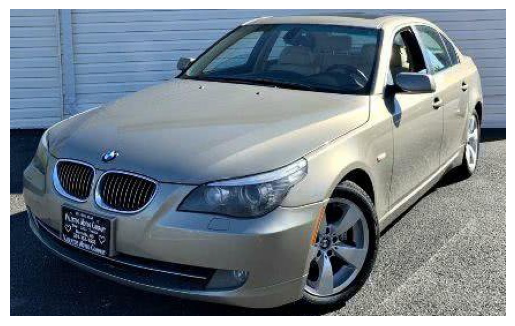

In [12]:
# Define the path to the image
img_path = r'vcor-vehicle-color-recognition-dataset/train/beige/00ecfeedea.jpg'

# Read the image using plt.imread()
img = plt.imread(img_path)

# Print the shape of the input image
print('Input image shape is', img.shape)

# Turn off axis ticks and labels for cleaner display
plt.axis('off')

# Display the image using plt.imshow()
plt.imshow(img)

# Show the plot
plt.show()

#### Pre-process Function to Read an Image File and Create Dataframes

In [13]:
def preprocess(sdir):
    categories = ['train', 'test', 'val']
    # Loop through each category
    for category in categories:
        catpath = os.path.join(sdir, category)
        filepaths = []
        labels = []
        
        # Get a list of classes within the current category
        classlist = os.listdir(catpath)
        
        # Loop through each class
        for klass in classlist:
            classpath = os.path.join(catpath, klass)
            flist = os.listdir(classpath)
            
            # Loop through each file within the class
            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(klass)
        
        # Create Series for filepaths and labels
        Fseries = pd.Series(filepaths, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        
        # Based on the category, create or update the corresponding DataFrame
        if category == 'train':
            train_df = pd.concat([Fseries, Lseries], axis=1)
        elif category == 'test':
            test_df = pd.concat([Fseries, Lseries], axis=1)
        else:
            valid_df = pd.concat([Fseries, Lseries], axis=1)
    
    # Print the lengths of the dataframes
    print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))
    
    # Check if the number of classes in train_df matches with test_df and valid_df
    trcount = len(train_df['labels'].unique())
    tecount = len(test_df['labels'].unique())
    vcount = len(valid_df['labels'].unique())
    
    # Display warnings if the number of classes doesn't match as it could cause errors during training
    if trcount < tecount:
        print_in_color('** WARNING ** number of classes in training set is less than the number of classes in test set', (255,0,0), (55,65,80))
        print_in_color('This will throw an error in either model.evaluate or model.predict', (255,0,0), (55,65,80))
    
    if trcount != vcount:
        print_in_color('** WARNING ** number of classes in training set not equal to number of classes in validation set', (255,0,0), (55,65,80))
        print_in_color('This will throw an error in model.fit', (255,0,0), (55,65,80))
        print('train df class count:', trcount, 'test df class count:', tecount, 'valid df class count:', vcount)
        ans = input('Enter C to continue execution or H to halt execution')
        
        if ans == 'H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')
    
    # Print the image count per class in train_df to evaluate balance
    print_in_color('Below is image count per class to evaluate train_df balance', (0,255,255), (55,65,80))
    print(list(train_df['labels'].value_counts()))
    
    return train_df, test_df, valid_df

In [14]:
sdir = r'vcor-vehicle-color-recognition-dataset'

# Call the preprocess function with the provided directory path
train_df, test_df, valid_df = preprocess(sdir)

train_df length: 7267 test_df length: 1556 valid_df length: 1550
Below is image count per class to evaluate train_df balance

[742, 637, 577, 565, 563, 536, 534, 483, 428, 421, 406, 403, 400, 362, 210]


In [15]:
max_samples = 400
min_samples = 0
column = 'labels'
working_dir = r'./'
img_size = (224, 224)

# Call the balance function with the provided arguments
train_df = balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe: 15
[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 362, 210]
Found 210 validated image filenames.
Found 362 validated image filenames.
Total Augmented images created: 228
Final class distribution: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


### Create train, Test and Validation Generators

In [16]:
channels = 3  # Number of color channels in the images
batch_size = 40  # Batch size for training
img_shape = (img_size[0], img_size[1], channels)  # Image shape (height, width, channels)

length = len(test_df)
# Determine an appropriate batch size for the test data based on its length
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)

# Define a preprocessing function called "scalar" which doesn't modify the images
def scalar(img):
    return img  # EfficientNet expects pixels in the range 0 to 255, so no scaling is required

# Create ImageDataGenerator instances for training, testing, and validation data
trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # For training
tvgen = ImageDataGenerator(preprocessing_function=scalar)  # For testing and validation

# Display messages indicating generator setup for each dataset
msg = 'For the train generator'
print_in_color(msg, (0, 255, 255), (55, 65, 80))
# Flow training images from the dataframe using the defined generators
train_gen = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

msg = 'For the test generator'
print_in_color(msg, (0, 255, 255), (55, 65, 80))
# Flow test images from the dataframe using the defined generators
test_gen = tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

msg = 'For the validation generator'
print_in_color(msg, (0, 255, 255), (55, 65, 80))
# Flow validation images from the dataframe using the defined generators
valid_gen = tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                     class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Extract the class names and count from the training generator
classes = list(train_gen.class_indices.keys())
class_count = len(classes)

# Calculate the number of steps needed for each epoch during training
train_steps = int(np.ceil(len(train_gen.labels) / batch_size))

# Extract the labels from the test generator for later evaluation
labels = test_gen.labels

test batch size: 4   test steps: 389
For the train generator

Found 6000 validated image filenames belonging to 15 classes.
For the test generator

Found 1556 validated image filenames belonging to 15 classes.
For the validation generator

Found 1550 validated image filenames belonging to 15 classes.


### Display Some Training Images

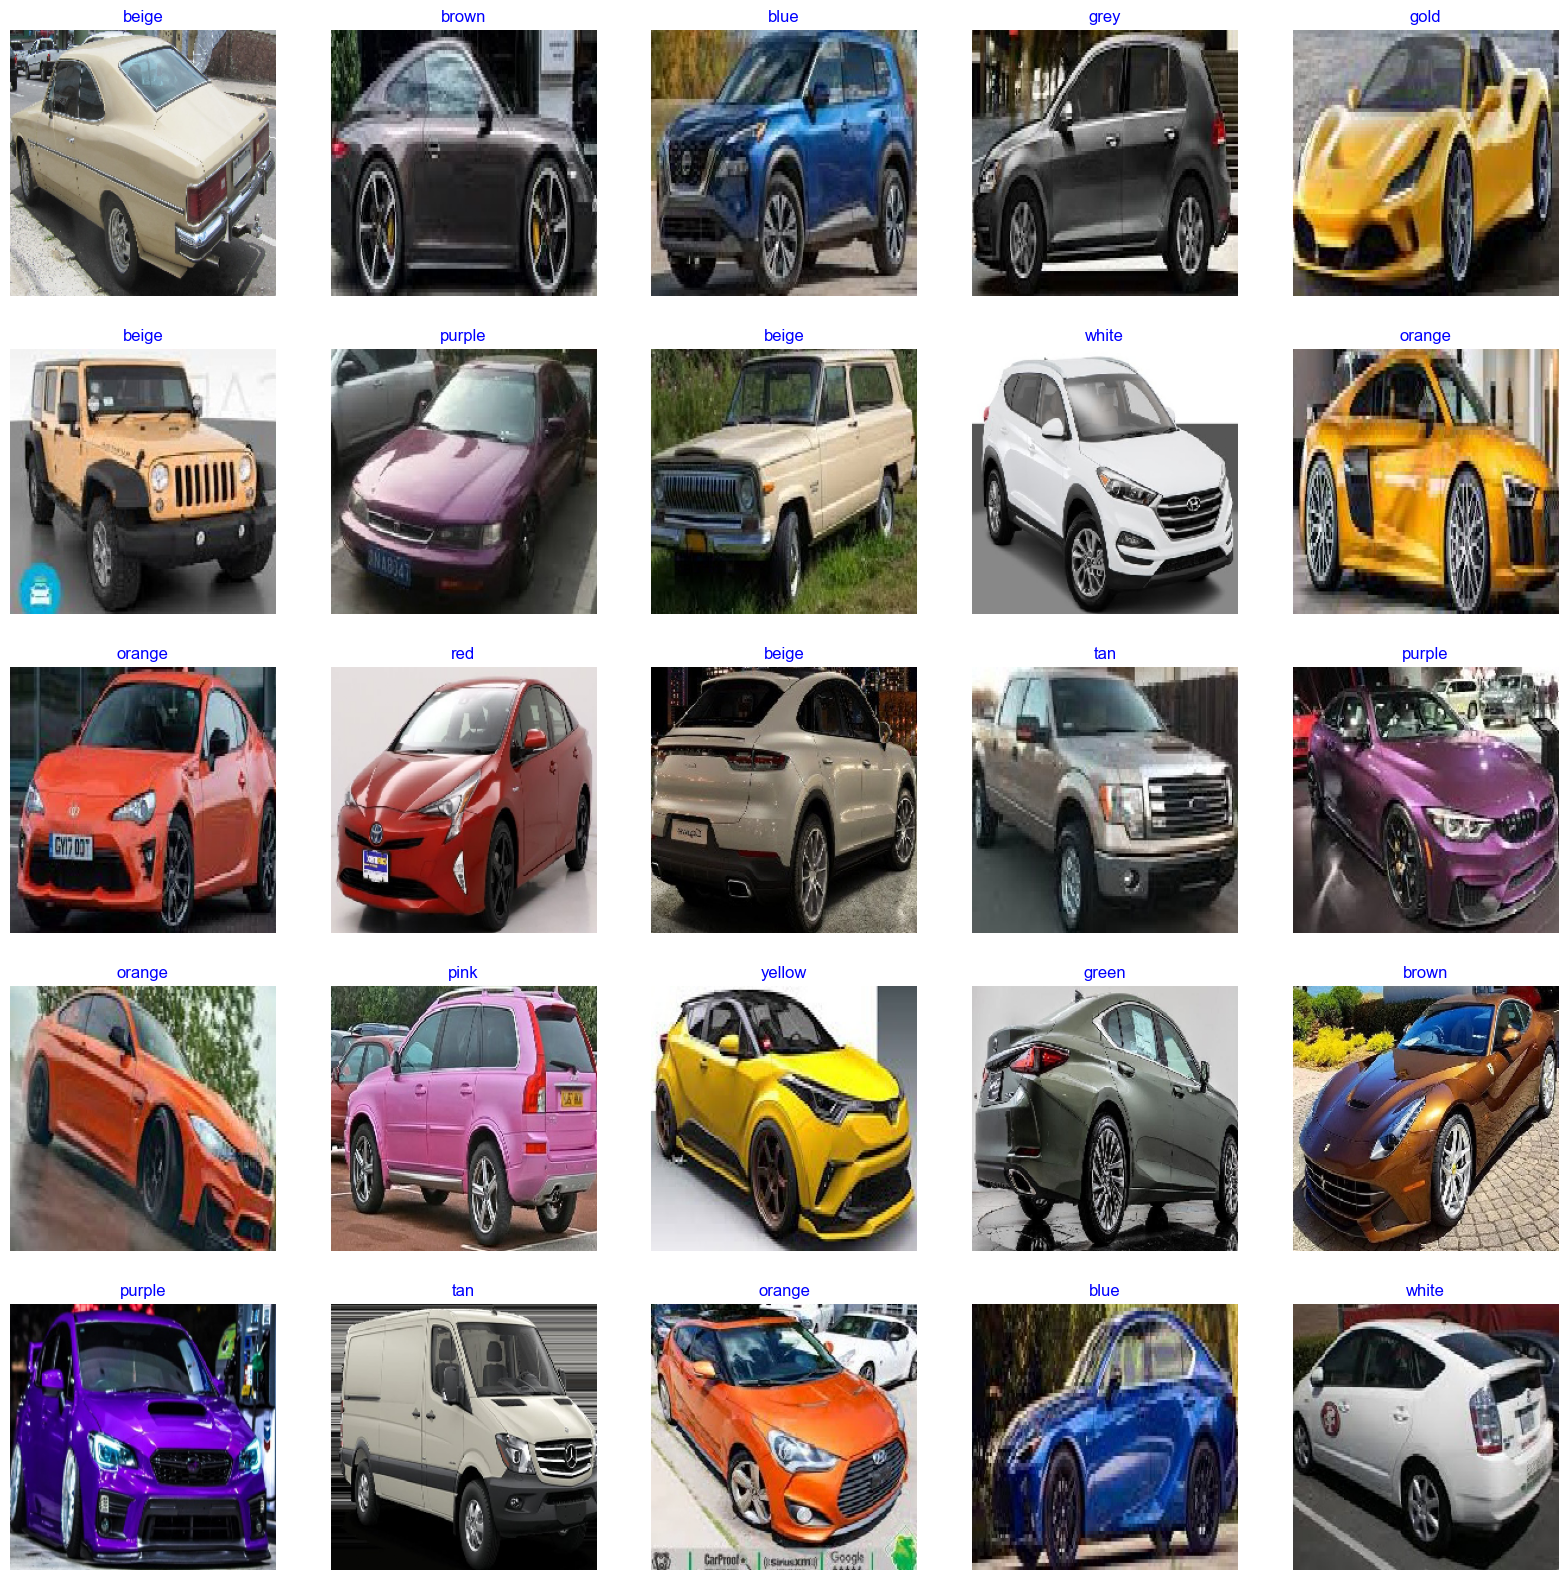

In [17]:
show_image_samples(train_gen)

### Create and Compile the Model

In [18]:
model_name = 'EfficientNetB3'  # A name for the model

# Load the EfficientNetB3 model with pre-trained weights from ImageNet
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
) 

# Define the architecture of the model
x = base_model.output  # Use the output of the EfficientNetB3 model as the input for the following layers

# Apply Batch Normalization layer for regularization and normalization
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# Add a Dense (fully connected) layer with regularization and activation function
x = Dense(256,
          kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

# Apply Dropout for regularization
x = Dropout(rate=0.45, seed=123)(x)  # Keep 55% of the neurons

# Add the final output layer with softmax activation for classification
output = Dense(class_count, activation='softmax')(x)  # class_count is the number of output classes

# Create the model by specifying the input and output layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model using Adamax optimizer and categorical cross-entropy loss
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Instantiate the Custom Callback and Train the Model

In [19]:
epochs = 10  # Number of training epochs
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold, adjust monitored accuracy; otherwise, monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
dwell = True  # Experimental option: if True and monitored metric doesn't improve, revert model weights to previous epoch's weights
freeze = False  # If True, freeze weights of the base model
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = train_steps  # Number of batches per epoch
# Define a custom callback for learning rate adjustments based on training progress
callbacks = [
    LRA(model=model, base_model=base_model, patience=patience, stop_patience=stop_patience, threshold=threshold,
        factor=factor, dwell=dwell, batches=batches, initial_epoch=0, epochs=epochs, ask_epoch=ask_epoch)
]

In [20]:
history = model.fit(
    x=train_gen,  # Training data generator
    epochs=epochs,  # Number of training epochs
    verbose=0,  # Set to 0 for no progress bar during training, set to 1 or 2 for progress information
    callbacks=callbacks,  # List of callback functions for monitoring training progress and adjusting parameters
    validation_data=valid_gen,  # Validation data generator
    validation_steps=None,  # Number of validation steps per epoch (automatically determined if None)
    shuffle=False,  # Set to False to maintain the order of data in the generator (important if you have specific evaluation metrics)
    initial_epoch=0  # Starting epoch number, useful for resuming training from a specific point
)

 initializing callback starting training with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /10     7.917   60.700   6.21223  80.065   0.00100  0.00100  accuracy     0.00   4081.18 

 2 /10     5.238   80.933   4.35594  84.710   0.00100  0.00100  accuracy    33.33   4570.63 

 3 /10     3.682   86.350   3.10200  85.677   0.00100  0.00100  accuracy     6.69   3874.48 

 4 /10     2.613   89.550   2.28767  85.871   0.00100  0.00100  accuracy     3.71   3892.73 

 5 /10     1.858   92.483   1.73491  85.677   0.00100  0.00100  val_loss    24.16   2766.05 

enter H to halt training or an integer for number of epochs to run then ask again

3
 training will continue until epoch 8

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /10     1.325   94.983   1.33360  87.806   0.00100  0.00100  val_loss    23.13   1817.74 

 7 /10     0.983   95.983   1.12681  86.710   0.00100  0.0

### Plot Training Data, Evaluate and Save the Model

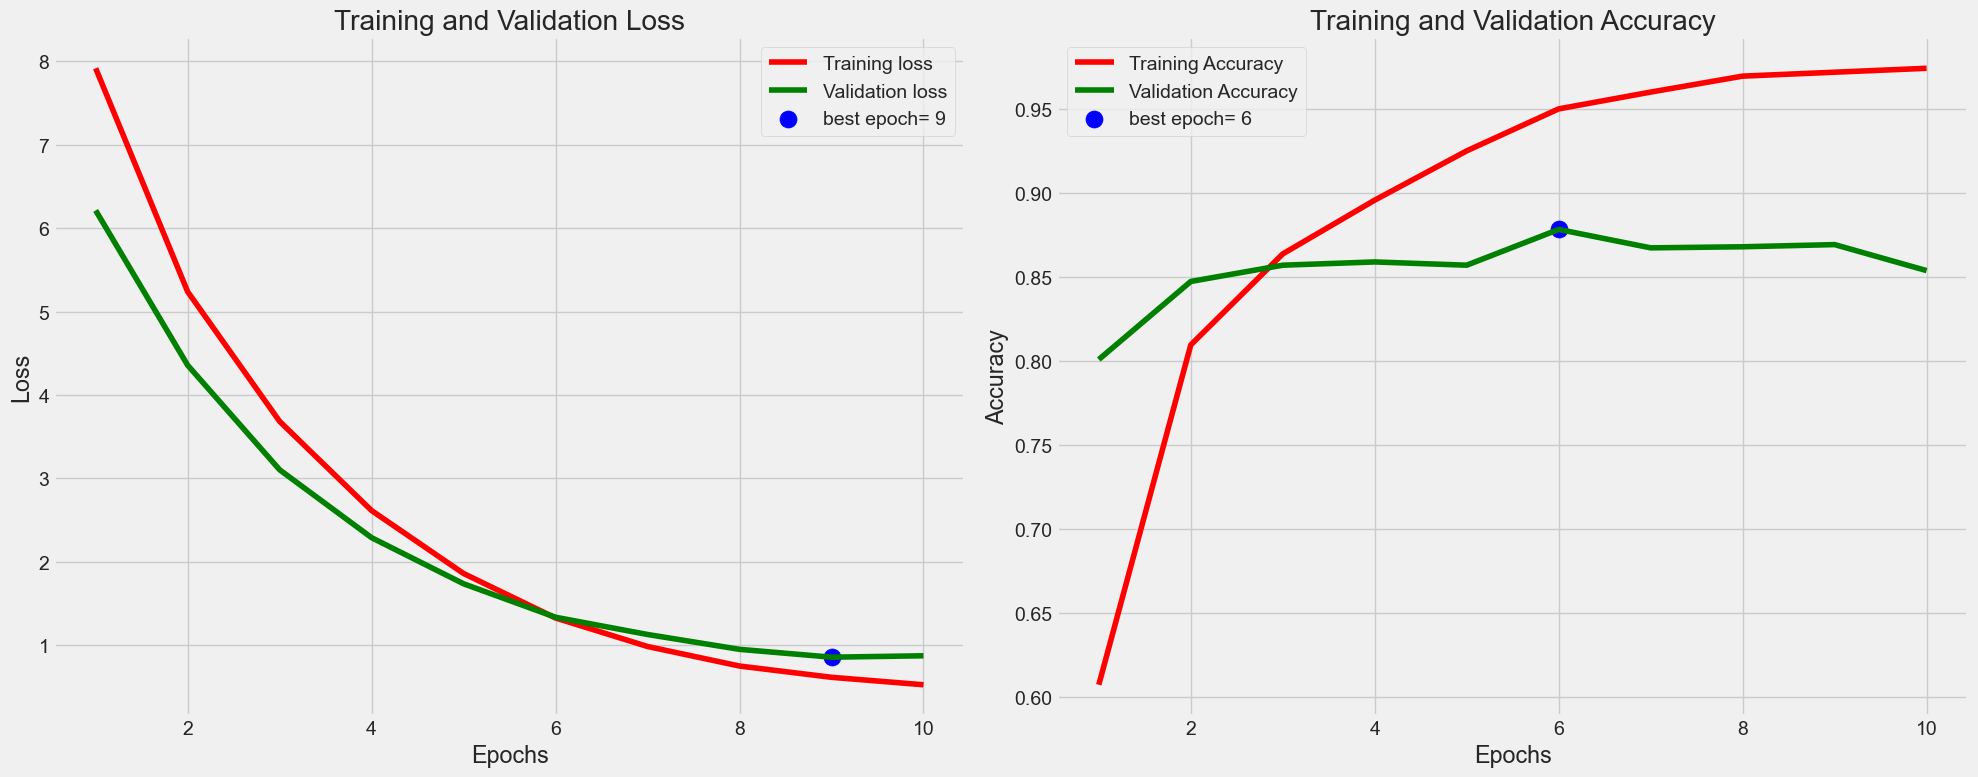

389/389 [==============================] - 320s 821ms/step - loss: 0.8567 - accuracy: 0.8638
accuracy on the test set is 86.38 %



In [24]:
tr_plot(history, 0)  # Plot training and validation loss and accuracy using the provided tr_plot function
subject = 'car color'  # Specify the subject for saving the model and CSV file

# Evaluate the model on the test set and calculate accuracy
acc = model.evaluate(test_gen, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))  # Print accuracy in color

generator = train_gen  # Use the training data generator for creating the class dictionary
scale = 1  # Set the scale factor

# Save the trained model and create a class dictionary CSV file using the saver function
# model_save_loc, csv_save_loc = saver(working_dir, model, model_name, subject, acc, img_size, scale, generator)

### Make Predictions on Test Set, Create Confusion Matrix and Classification Report

389/389 [==============================] - 321s 815ms/step


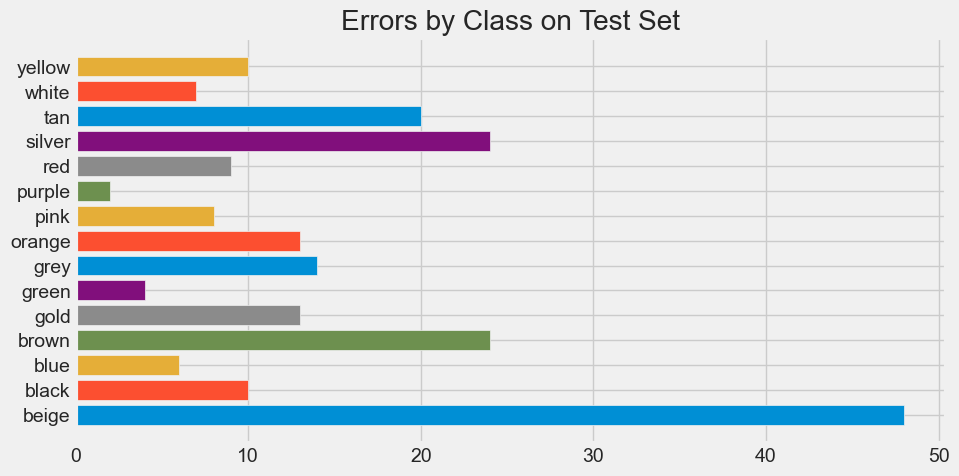

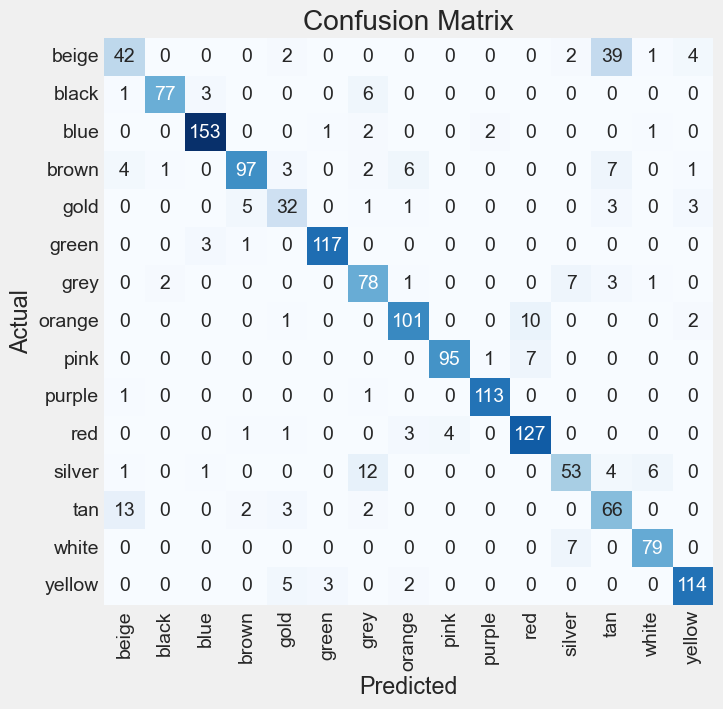

Classification Report:
----------------------
               precision    recall  f1-score   support

       beige       0.68      0.47      0.55        90
       black       0.96      0.89      0.92        87
        blue       0.96      0.96      0.96       159
       brown       0.92      0.80      0.85       121
        gold       0.68      0.71      0.70        45
       green       0.97      0.97      0.97       121
        grey       0.75      0.85      0.80        92
      orange       0.89      0.89      0.89       114
        pink       0.96      0.92      0.94       103
      purple       0.97      0.98      0.98       115
         red       0.88      0.93      0.91       136
      silver       0.77      0.69      0.73        77
         tan       0.54      0.77      0.63        86
       white       0.90      0.92      0.91        86
      yellow       0.92      0.92      0.92       124

    accuracy                           0.86      1556
   macro avg       0.85      0.84

In [22]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

### Using the Trained Model to Classify Image Files

Input image shape is (266, 430, 3)
The resized image has shape (224, 224, 3)
Image shape after expanding dimensions is (1, 224, 224, 3)
1/1 [==============================] - 5s 5s/step
The shape of the prediction is (1, 15)
The image is predicted as being color beige with a probability of 81.67616724967957


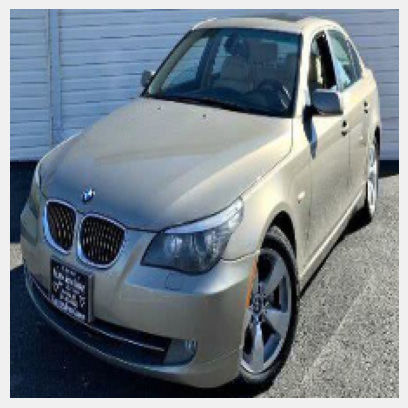

In [23]:
fpath = r'vcor-vehicle-color-recognition-dataset/train/beige/00ecfeedea.jpg'
img = plt.imread(fpath)
print('Input image shape is', img.shape)
# Resize the image to match the size used for training the model
img = cv2.resize(img, img_size)  # img_size = (224, 224) used for training
print('The resized image has shape', img.shape)

# Display the resized image
plt.axis('off')
plt.imshow(img)

# The following lines of code were commented out to maintain the pixel range between 0 and 255
# img = img / 255
# plt.imread returns a numpy array, no need to convert to numpy array again

# Expand the dimensions of the image to match the batch size for model.predict
img = np.expand_dims(img, axis=0)
print('Image shape after expanding dimensions is', img.shape)

# Make a prediction on the image using the trained model
pred = model.predict(img)
print('The shape of the prediction is', pred.shape)

# Since this dataset has 15 classes, model.predict will return a list of 15 probability values
# We find the index of the column with the highest probability
index = np.argmax(pred[0])

# Get the actual class name from the 'classes' list
klass = classes[index]

# Get the value of the highest predicted probability
probability = pred[0][index] * 100

# Print the predicted class and its probability
print('The image is predicted as being color', klass, 'with a probability of', probability)